In [1]:
import pickle
import pandas as pd
import datetime
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Corners Race Requirements

##### Parameters
- Favorites odds to win < 2.0
- Favorite teams is the home team
- Min minute to bet: 65'
- Max minute to bet: 85'
- Favorite team losing or the game is tied
- Ball Posession: 55%+
- Favorite with more corners
- Favorite with more shots and shots on goal
- Favorite with more attacks or dangerous attacks

##### Criteria to bet (personal choice)
- Bet on the upcoming corner race (5 corners then 7 not 9)
- Minimum odds 1.8
- Max odds: none
- Stake 1.0 (constant)

#### Bet again in the same match
- Only bet again if you won the first bet on the match
- Stake .5

### Cleaning the Data (Blogabet)

In [2]:
#you don't need to do the cleaning part. The csv in ready in the "Read CSV" step

df_blogabet = pickle.load(open('df_blogabet_corners', 'rb'))
df_blogabet = df_blogabet[df_blogabet['markets'].str.contains('Corner')]
df_blogabet.reset_index(inplace=True, drop=True)
#simple regex pattern
df_blogabet[['market','odds']] = df_blogabet['markets'].str.extract(r'\((.+)\) .+ @ (.+)')
#split by blank space
df_blogabet[['stake', 'event', 'bookie', 'i', 'balance', 'nan', 'corners']] =  df_blogabet['labels'].apply(lambda x: x.split(' ')).apply(pd.Series)
#split by '/'
df_blogabet['stake'] = df_blogabet['stake'].apply(lambda x:x.split('/')[0])
#filter out cells without digits in balance colum
df_blogabet = df_blogabet[df_blogabet['balance'].str.contains('\d')]
#get the date in correct format
df_blogabet['dates'] = df_blogabet['dates'].str.extract(r'/ Kick off: (.+)').astype(str)
df_blogabet['dates'] = df_blogabet['dates'].apply(lambda x: datetime.datetime.strptime(x, '%d %b %Y, %H:%M'))

#selecting columns and giving approapiate data type
df_blogabet = df_blogabet[['dates', 'teams','market', 'odds', 'stake', 'event', 'bookie', 'balance', 'corners']]
df_blogabet = df_blogabet.astype({'odds':float, 'balance':float, 'stake':int})
#creating "result" column with loss-win data
df_blogabet['result'] = np.where(df_blogabet['balance']<0, 'Loss', 'Win')
#removing one row thatisn't corner race
df_blogabet = df_blogabet.drop([0], axis=0).reset_index(drop=True)
df_blogabet

,dates,teams,market,odds,stake,event,bookie,balance,corners,result
0,2019-08-01 14:00:00,FC Astana v FC Santa Coloma,Corners Race,2.500,1,LIVE,Bet365,-1.00,6-3,Loss
1,2019-07-28 12:30:00,Anderlecht v KV Oostende,Corners Race,1.800,2,LIVE,Bet365,1.60,5-2,Win
2,2019-07-28 11:30:00,Hamburg v Darmstadt,Corners Race,2.000,3,LIVE,Bet365,-3.00,7-3,Loss
3,2019-07-27 18:30:00,San Lorenzo v Godoy Cruz,Corners Race,2.375,2,LIVE,Bet365,2.75,7-2,Win
4,2019-07-27 16:00:00,Jonkopings Sodra v Degerfors,Corners Race,1.909,2,LIVE,Bet365,1.82,7-2,Win
...,...,...,...,...,...,...,...,...,...,...
195,2019-01-30 15:15:00,PAOK Salonika v Giannina,Race to 7 Corners (Count : 4:1),2.750,1,LIVE,Bet365,1.75,7-1,Win
196,2019-01-27 17:00:00,Panathinaikos v Larissa,Race to 5 Corners (Count : 3:0),1.833,1,LIVE,Bet365,0.83,5-0,Win
197,2019-01-27 13:30:00,FC Utrecht v Willem II,Race to 9 Corners (Count : 6:1),2.100,2,LIVE,Bet365,-2.00,8-1,Loss
198,2019-01-27 07:00:00,Adelaide United v Central Coast Mariners,Race to 9 Corners (Count : 7:1),1.909,1,LIVE,Bet365,0.91,9-3,Win


In [3]:
#conflict with corners column datetype (excel messes up "corners" data)
df_blogabet.drop('corners', axis=1, inplace=True)
#saving to .csv, to add 'competition' column 
# df_blogabet.to_csv('telegram_bot.csv', index=False)

### Reading .csv file:  Competition column was added

In [5]:
#reading csv with 'competition' column added
df_telegram_bot = pd.read_csv('telegram_bot_corners_data.csv', parse_dates=['dates'])
df_telegram_bot = df_telegram_bot.sort_values('dates').reset_index(drop=True)
df_telegram_bot

,dates,competition,teams,market,odds,stake,event,bookie,balance,result
0,2019-01-26 14:30:00,Germany,Borussia M'gladbach v Augsburg,Race to 5 Corners (Count : 3:0),2.250,1,LIVE,Bet365,-1.00,Loss
1,2019-01-27 07:00:00,Australia,Adelaide United v Central Coast Mariners,Race to 9 Corners (Count : 7:1),1.909,1,LIVE,Bet365,0.91,Win
2,2019-01-27 13:30:00,Netherlands,FC Utrecht v Willem II,Race to 9 Corners (Count : 6:1),2.100,2,LIVE,Bet365,-2.00,Loss
3,2019-01-27 17:00:00,Greece,Panathinaikos v Larissa,Race to 5 Corners (Count : 3:0),1.833,1,LIVE,Bet365,0.83,Win
4,2019-01-30 15:15:00,Greece,PAOK Salonika v Giannina,Race to 7 Corners (Count : 4:1),2.750,1,LIVE,Bet365,1.75,Win
...,...,...,...,...,...,...,...,...,...,...
195,2019-07-27 16:00:00,Sweden,Jonkopings Sodra v Degerfors,Corners Race,1.909,2,LIVE,Bet365,1.82,Win
196,2019-07-27 18:30:00,Argentina,San Lorenzo v Godoy Cruz,Corners Race,2.375,2,LIVE,Bet365,2.75,Win
197,2019-07-28 11:30:00,Germany,Hamburg v Darmstadt,Corners Race,2.000,3,LIVE,Bet365,-3.00,Loss
198,2019-07-28 12:30:00,Belgium,Anderlecht v KV Oostende,Corners Race,1.800,2,LIVE,Bet365,1.60,Win


### Monthly Analysis

In [6]:
df_month = df_telegram_bot.copy()
df_month['dates'] = df_month['dates'].apply(lambda x:x.strftime('%B %Y'))
df_month['dates'] = pd.to_datetime(df_month['dates'])
df_month = df_month.sort_values('dates')
# average odds and stake
df_average_odds_stake = df_month.groupby('dates').mean()[['odds', 'stake']]
# total picks
df_picks = df_month.groupby('dates').count()
df_picks = df_picks[['teams']].rename(columns={'teams':'picks'})
#mean wins-loss
df_win_loss = df_month.groupby(['dates','result'], as_index=False).count().pivot(
    index='dates', columns='result', values='teams')

df_win_loss['%Win'] = round(df_win_loss['Win']/(df_win_loss['Loss'] + df_win_loss['Win'])*100, 2)

#balance per month
df_balance = df_month.groupby('dates').sum()
df_balance = df_balance[['balance']]

df_analysis = pd.concat([
    df_average_odds_stake, df_picks, df_win_loss, df_balance
], axis=1)
df_analysis
#datawrapper
# for i in df_analysis.reset_index().values:
#     print(str(i[0])+', '+f'{i[1]:.2f}'+', '+f'{i[2]:.2f}'+', '+str(i[3])+', '+str(i[4])+', '+str(i[5])+', '+str(i[6])+', '+f'{i[7]:.2f}')
# total
# df_analysis.sum()
# df_analysis.mean()

,odds,stake,picks,Loss,Win,%Win,balance
dates,,,,,,,
2019-01-01,2.173667,1.333333,6,2.0,4.0,66.67,2.89
2019-02-01,2.601394,1.303030,33,13.0,20.0,60.61,25.49
2019-03-01,3.134520,1.120000,50,30.0,20.0,40.00,7.39
2019-04-01,3.367773,1.522727,44,27.0,17.0,38.64,5.37
2019-05-01,2.735542,1.833333,24,12.0,12.0,50.00,8.73
2019-06-01,3.504462,1.615385,13,9.0,4.0,30.77,-0.10
2019-07-01,2.520793,1.689655,29,16.0,13.0,44.83,2.30
2019-08-01,2.500000,1.000000,1,1.0,NaN,NaN,-1.00


### Graph

In [7]:
df_graph_cumsum = df_telegram_bot.copy()
df_graph_cumsum['dates'] = df_graph_cumsum['dates'].apply(lambda x:x.strftime('%Y-%m-%d'))
df_graph_cumsum = df_telegram_bot.groupby('dates', as_index=False).sum()
df_graph_cumsum['balance_cumsum'] = df_graph_cumsum['balance'].cumsum()

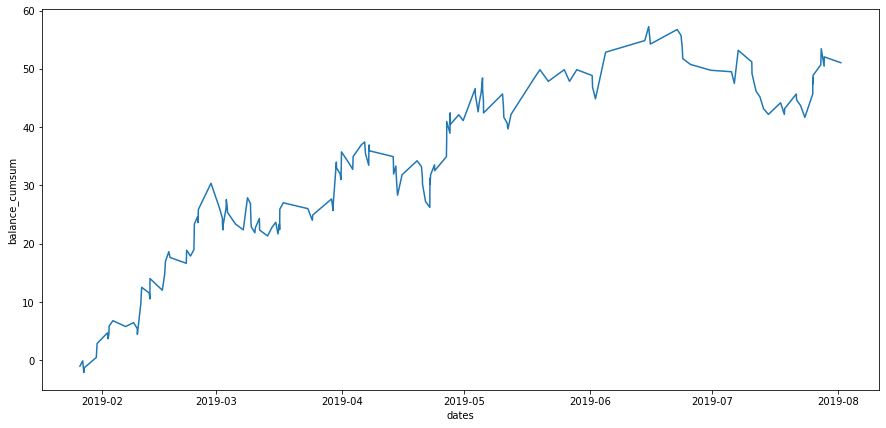

In [8]:
df_graph_cumsum['dates'] = pd.to_datetime(df_graph_cumsum['dates'])
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(ax=ax, data=df_graph_cumsum, x='dates', y='balance_cumsum')
plt.show()

### Competition analysis (more than 10 games)

In [9]:
#selecting competitions with 10 or more samples
df = df_telegram_bot.groupby('competition').count()
ten_games_or_more = df[df['dates']>=10].index

df_competition = df_telegram_bot.copy()
df_competition['competition'] = np.where(df_telegram_bot['competition'].isin(ten_games_or_more), df_telegram_bot['competition'],
         'Rest of the World')

#average odds and stake
df_average_odds_stake = df_competition.groupby('competition').mean()
df_average_odds_stake = df_average_odds_stake[['odds', 'stake']]
#total picks
df_picks = df_competition.groupby('competition').count()
df_picks = df_picks[['dates']].rename(columns={'dates':'picks'})
#mean wins-loss
df_win_loss = df_competition.groupby(['competition','result'], as_index=False).count().pivot(
    index='competition', columns='result', values='dates')
df_win_loss['%Win'] = round(df_win_loss['Win']/(df_win_loss['Loss'] + df_win_loss['Win'])*100, 2)
#balance per competition
df_balance = df_competition.groupby('competition').sum()
df_balance = df_balance[['balance']]

df_analysis = pd.concat([
    df_average_odds_stake, df_picks, df_win_loss, df_balance
], axis=1)

df_analysis

#datawrapper 
# for i in df_analysis.reset_index().values:
#     print(i[0]+', '+f'{i[1]:.2f}'+', '+f'{i[2]:.2f}'+', '+str(i[3])+', '+str(i[4])+', '+str(i[5])+', '+str(i[6])+', '+f'{i[7]:.2f}')
#total
# df_analysis.sum()
# df_analysis.mean()

,odds,stake,picks,Loss,Win,%Win,balance
competition,,,,,,,
Europa League,2.745929,1.285714,14,8,6,42.86,1.20
France,2.867083,1.666667,12,4,8,66.67,11.88
Italy,2.754636,1.454545,11,4,7,63.64,10.47
Japan,2.506750,1.750000,12,2,10,83.33,20.54
Netherlands,3.661545,1.454545,11,7,4,36.36,0.43
Rest of the World,2.924763,1.408602,93,61,32,34.41,-22.67
Spain,3.334091,1.454545,11,6,5,45.45,5.09
Sweden,3.239200,1.700000,10,4,6,60.00,8.07
United Kingdom,2.924346,1.307692,26,14,12,46.15,16.06


#### Total statistics

In [10]:
print('Picks: '+str(len(df_telegram_bot)))
print('Win Rate: '+str((df_telegram_bot.groupby('result').count().loc['Win', 'dates']/len(df_telegram_bot))*100))
print('Profit: '+str(df_telegram_bot['balance'].sum()))
print('Yield: '+str(df_telegram_bot['balance'].sum()/df_telegram_bot['stake'].sum()*100))
print('Avg Odds: '+str(df_telegram_bot['odds'].mean()))
print('Avg Stake: '+str(df_telegram_bot['stake'].mean()))

Picks: 200
Win Rate: 45.0
Profit: 51.07000000000001
Yield: 17.67128027681661
Avg Odds: 2.95305
Avg Stake: 1.445


In [11]:
#for datawrapper:
# for i in df_graph_cumsum[['dates', 'balance_cumsum']].values:
#     print(str(i[0]) + ', ' +str(round(i[1], 2)))

In [12]:
#for Datawrapper
# for i in df_telegram_bot.values:
#     print(str(i[0])+', '+i[1]+', '+i[2]+', '+str(i[3])+', '+str(i[4])+', '+str(i[7])+', '+i[8]+', '+i[10])

In [13]:
#for Datawrapper
# for i in df_telegram_bot.groupby('competition', as_index=False).count().values:
#     print(i[1])
# +', '+str(i[1])